# Fraud Detection - Data Preprocessing & Model Training
## Azure Cloud Data-Driven Application Project

**Project:** Detection of fraud in financial transactions  
**Dataset:** 6M rows → Truncated & Balanced for optimal training  
**Goal:** Train a high-performance fraud detection model

---

## Pipeline Overview:
1. **Data Loading & Exploration**
2. **Strategic Truncation** (All frauds + 500k non-frauds)
3. **Data Balancing with SMOTE** (40/60 or customizable ratio)
4. **Feature Engineering & Preprocessing**
5. **Model Training** (Multiple algorithms)
6. **Model Evaluation & Comparison**
7. **Export Best Model** for deployment

## 📦 1. Import Required Libraries

In [1]:
pip install mlflow

  Using cached mlflow_skinny-3.7.0-py3-none-any.whl.metadata (31 kB)
Using cached mlflow_skinny-3.7.0-py3-none-any.whl (2.4 MB)
  Attempting uninstall: mlflow-skinny
    Found existing installation: mlflow-skinny 3.5.0
    Uninstalling mlflow-skinny-3.5.0:
      Successfully uninstalled mlflow-skinny-3.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
azureml-mlflow 1.61.0.post1 requires mlflow-skinny<=3.5.0, but you have mlflow-skinny 3.7.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install xgboost lightgbm
%pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Data preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.utils import resample

# Balancing techniques
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN

# Machine Learning models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)

# Model persistence
import joblib
import pickle

# For experiment tracking (if using MLflow)
try:
    import mlflow
    import mlflow.sklearn
    MLFLOW_AVAILABLE = True
    print("✅ MLflow is available for experiment tracking")
except ImportError:
    MLFLOW_AVAILABLE = False
    print("⚠️ MLflow not available. Install with: pip install mlflow")

print("\n✅ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✅ MLflow is available for experiment tracking

✅ All libraries imported successfully!
Pandas version: 2.3.1
NumPy version: 2.2.6


## 📊 2. Load and Explore Dataset

In [4]:
!pip install azureml-dataset-runtime --upgrade

In [5]:
# Configuration
from datetime import datetime
import pandas as pd
from azureml.core import Workspace, Dataset

DATA_PATH = 'fraud_dataset.csv'  
TARGET_COLUMN = 'isFraud'

print("📂 Loading dataset...")
print(f"File: {DATA_PATH}")
print(f"Loading started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

# Connect to Azure ML Workspace
ws = Workspace.from_config()
datastore = ws.get_default_datastore()

# Load dataset FROM BLOB STORAGE
dataset = Dataset.Tabular.from_delimited_files(
    path=[(datastore, DATA_PATH)]
)

df = dataset.to_pandas_dataframe()

print(f"✅ Dataset loaded successfully!")
print(f"Loading completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

# Display basic information
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Total rows: {df.shape[0]:,}")
print(f"Total columns: {df.shape[1]:,}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nFirst few rows:")
display(df.head())


📂 Loading dataset...
File: fraud_dataset.csv
Loading started at: 2025-12-16 19:55:04

{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}
✅ Dataset loaded successfully!
Loading completed at: 2025-12-16 19:55:16

DATASET OVERVIEW
Total rows: 6,362,620
Total columns: 11
Memory usage: 1610.36 MB

First few rows:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,True,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,False,False
1,True,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,False,False
2,True,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,True,False
3,True,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,True,False
4,True,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,False,False


In [6]:
# Examine data types and missing values
print("\n" + "="*60)
print("DATA QUALITY CHECK")
print("="*60)

print("\n📋 Column Information:")
df.info()

print("\n❓ Missing Values:")
missing = df.isnull().sum()
missing_pct = 100 * missing / len(df)
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing Count', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])

print("\n📊 Basic Statistics:")
display(df.describe())


DATA QUALITY CHECK

📋 Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            object 
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         bool   
 10  isFlaggedFraud  bool   
dtypes: bool(2), float64(5), object(4)
memory usage: 449.0+ MB

❓ Missing Values:
      Missing Count  Percentage
step        6359912   99.957439

📊 Basic Statistics:


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06
std,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05
75%,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06
max,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08


## 🎯 3. Analyze Class Distribution (Before Truncation)

CLASS DISTRIBUTION ANALYSIS

📊 Original Dataset Distribution:

Non-Fraud (0): 6,354,407 (99.87%)
Fraud (1):     8,213 (0.13%)

Imbalance Ratio: 1:773.7
Total samples: 6,362,620


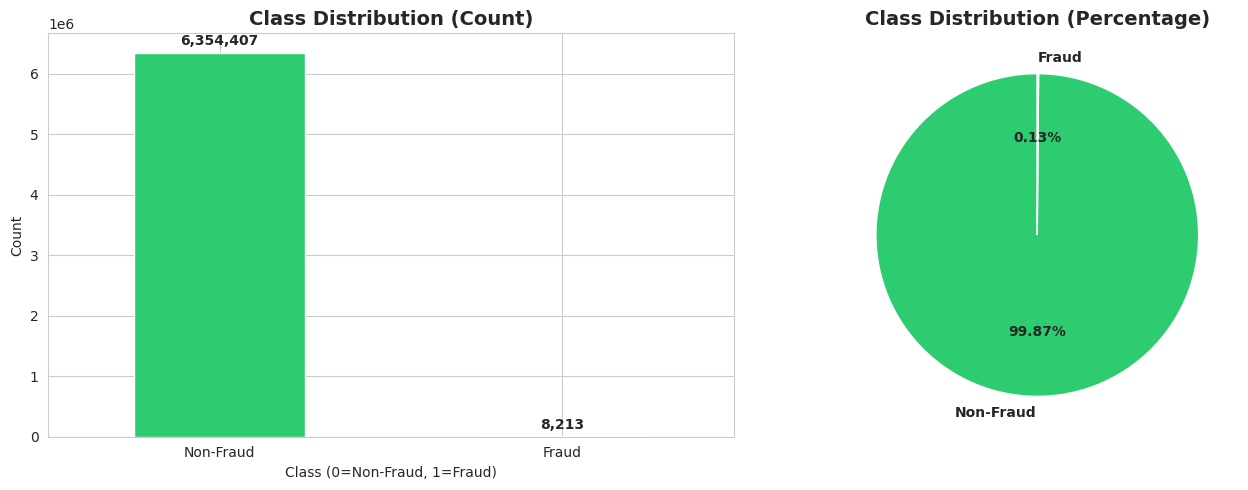


⚠️ This dataset is highly imbalanced - balancing is necessary!


In [7]:
import matplotlib.pyplot as plt
print("="*60)
print("CLASS DISTRIBUTION ANALYSIS")
print("="*60)

# Count fraud vs non-fraud cases
fraud_counts = df[TARGET_COLUMN].value_counts()
fraud_pct = df[TARGET_COLUMN].value_counts(normalize=True) * 100

print("\n📊 Original Dataset Distribution:")
print(f"\nNon-Fraud (0): {fraud_counts[0]:,} ({fraud_pct[0]:.2f}%)")
print(f"Fraud (1):     {fraud_counts[1]:,} ({fraud_pct[1]:.2f}%)")
print(f"\nImbalance Ratio: 1:{fraud_counts[0]/fraud_counts[1]:.1f}")
print(f"Total samples: {len(df):,}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
fraud_counts.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class (0=Non-Fraud, 1=Fraud)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Non-Fraud', 'Fraud'], rotation=0)
for i, v in enumerate(fraud_counts):
    axes[0].text(i, v + max(fraud_counts)*0.02, f'{v:,}', ha='center', fontweight='bold')

# Pie chart
axes[1].pie(fraud_counts, labels=['Non-Fraud', 'Fraud'], autopct='%1.2f%%',
            colors=['#2ecc71', '#e74c3c'], startangle=90, textprops={'fontweight': 'bold'})
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n⚠️ This dataset is highly imbalanced - balancing is necessary!")

## ✂️ 4. Strategic Dataset Truncation

**Strategy:**
- Keep ALL fraud cases (minority class)
- Sample 500,000 non-fraud cases (majority class)
- This reduces computational load while preserving all fraud patterns

In [8]:
print("="*60)
print("DATASET TRUNCATION")
print("="*60)

# Separate fraud and non-fraud cases
fraud_cases = df[df[TARGET_COLUMN] == 1]
non_fraud_cases = df[df[TARGET_COLUMN] == 0]

print(f"\n📊 Original Split:")
print(f"Fraud cases:     {len(fraud_cases):,}")
print(f"Non-fraud cases: {len(non_fraud_cases):,}")

# Keep all frauds, sample non-frauds
NON_FRAUD_SAMPLE_SIZE = 500_000

print(f"\n✂️ Truncation Strategy:")
print(f"✓ Keep ALL {len(fraud_cases):,} fraud cases")
print(f"✓ Sample {NON_FRAUD_SAMPLE_SIZE:,} non-fraud cases")

# Random sampling of non-fraud cases
non_fraud_sampled = non_fraud_cases.sample(
    n=min(NON_FRAUD_SAMPLE_SIZE, len(non_fraud_cases)),
    random_state=42
)

# Combine truncated datasets
df_truncated = pd.concat([fraud_cases, non_fraud_sampled], axis=0)
df_truncated = df_truncated.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

print(f"\n✅ Truncation Complete!")
print(f"\n📊 Truncated Dataset:")
print(f"Total rows: {len(df_truncated):,}")
print(f"Fraud:      {len(df_truncated[df_truncated[TARGET_COLUMN] == 1]):,}")
print(f"Non-fraud:  {len(df_truncated[df_truncated[TARGET_COLUMN] == 0]):,}")

truncated_ratio = len(df_truncated[df_truncated[TARGET_COLUMN] == 0]) / len(df_truncated[df_truncated[TARGET_COLUMN] == 1])
print(f"\nNew Imbalance Ratio: 1:{truncated_ratio:.1f}")
print(f"Size reduction: {100 * (1 - len(df_truncated)/len(df)):.1f}%")

# Memory cleanup
del df, fraud_cases, non_fraud_cases, non_fraud_sampled
import gc
gc.collect()

print("\n🧹 Memory cleaned up")

DATASET TRUNCATION

📊 Original Split:
Fraud cases:     8,213
Non-fraud cases: 6,354,407

✂️ Truncation Strategy:
✓ Keep ALL 8,213 fraud cases
✓ Sample 500,000 non-fraud cases

✅ Truncation Complete!

📊 Truncated Dataset:
Total rows: 508,213
Fraud:      8,213
Non-fraud:  500,000

New Imbalance Ratio: 1:60.9
Size reduction: 92.0%

🧹 Memory cleaned up


## 🔧 5. Feature Engineering & Preprocessing

In [9]:
import sys
!{sys.executable} -m pip install category_encoders

In [10]:
import pandas as pd
import numpy as np

# Assuming df_truncated is already loaded
TARGET_COLUMN = 'isFraud'  # Replace with your actual target column name

# 1️⃣ Identify categorical columns
categorical_cols = df_truncated.select_dtypes(include=['object', 'category']).columns
numeric_cols = df_truncated.select_dtypes(include=[np.number]).columns

# 2️⃣ Handle missing values
print("="*60)
print("FEATURE ENGINEERING - Missing Values")
print("="*60)

for col in numeric_cols:
    if df_truncated[col].isnull().sum() > 0:
        df_truncated[col].fillna(df_truncated[col].median(), inplace=True)
        print(f"Filled missing values in {col} with median")

for col in categorical_cols:
    if df_truncated[col].isnull().sum() > 0:
        df_truncated[col].fillna(df_truncated[col].mode()[0], inplace=True)
        print(f"Filled missing values in {col} with mode")

# 3️⃣ Encode categorical columns using Target Encoding
!pip install -q category_encoders
import category_encoders as ce

if len(categorical_cols) > 0:
    print(f"\n🔤 Encoding {len(categorical_cols)} categorical columns using Target Encoding...")
    encoder = ce.TargetEncoder(cols=categorical_cols)
    df_truncated[categorical_cols] = encoder.fit_transform(df_truncated[categorical_cols], df_truncated[TARGET_COLUMN])
    print("✓ Encoding complete")
else:
    print("No categorical columns to encode")

# 4️⃣ Optional: Scale numeric columns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_truncated[numeric_cols] = scaler.fit_transform(df_truncated[numeric_cols])
df_processed = df_truncated.copy()

print("\n✓ Feature scaling complete")


FEATURE ENGINEERING - Missing Values
Filled missing values in step with mode

🔤 Encoding 4 categorical columns using Target Encoding...
✓ Encoding complete

✓ Feature scaling complete


## 🎯 6. Data Balancing with SMOTE

**Multiple balancing strategies available:**
- **SMOTE**: Synthetic Minority Over-sampling Technique
- **ADASYN**: Adaptive Synthetic Sampling
- **BorderlineSMOTE**: Focus on borderline cases
- **SMOTETomek**: SMOTE + Tomek Links cleaning

We'll use **SMOTE** with customizable ratio (40:60, 45:55, or 50:50)

In [11]:
import imblearn
from imblearn.over_sampling import SMOTE
print(imblearn.__file__)
print(SMOTE)


/anaconda/envs/jupyter_env/lib/python3.10/site-packages/imblearn/__init__.py
<class 'imblearn.over_sampling._smote.base.SMOTE'>


In [12]:
from imblearn.over_sampling import SMOTE
print("="*60)
print("DATA BALANCING WITH SMOTE")
print("="*60)

# Separate features and target
X = df_processed.drop(columns=[TARGET_COLUMN])
y = df_processed[TARGET_COLUMN]

print(f"\n📊 Before Balancing:")
print(f"Features shape: {X.shape}")
print(f"Target distribution:")
print(y.value_counts())
print(f"Fraud ratio: {100 * y.mean():.2f}%")

# Choose your desired balance ratio
# Options: 0.4 (40%), 0.45 (45%), 0.5 (50%)
DESIRED_FRAUD_RATIO = 0.40  # ⚠️ ADJUST THIS (0.40 = 40/60 split)

# Calculate sampling strategy
# sampling_strategy: ratio of minority class to majority class after resampling
# For 40% fraud: we want fraud/(non-fraud) = 0.4/0.6 = 0.667
sampling_strategy = DESIRED_FRAUD_RATIO / (1 - DESIRED_FRAUD_RATIO)

print(f"\n🎯 Target Balance:")
print(f"Desired fraud ratio: {DESIRED_FRAUD_RATIO*100:.0f}%")
print(f"Sampling strategy: {sampling_strategy:.3f}")

# Apply SMOTE
print(f"\n⚙️ Applying SMOTE...")
smote = SMOTE(
    sampling_strategy=sampling_strategy,
    random_state=42,
    k_neighbors=5)

X_balanced, y_balanced = smote.fit_resample(X, y)

print(f"\n✅ SMOTE Complete!")
print(f"\n📊 After Balancing:")
print(f"Features shape: {X_balanced.shape}")
print(f"Target distribution:")
print(pd.Series(y_balanced).value_counts())
fraud_pct_balanced = 100 * pd.Series(y_balanced).mean()
print(f"\nFraud ratio: {fraud_pct_balanced:.2f}%")
print(f"Total samples: {len(X_balanced):,}")
print(f"Synthetic samples created: {len(X_balanced) - len(X):,}")

DATA BALANCING WITH SMOTE

📊 Before Balancing:
Features shape: (508213, 10)
Target distribution:
isFraud
False    500000
True       8213
Name: count, dtype: int64
Fraud ratio: 1.62%

🎯 Target Balance:
Desired fraud ratio: 40%
Sampling strategy: 0.667

⚙️ Applying SMOTE...

✅ SMOTE Complete!

📊 After Balancing:
Features shape: (833333, 10)
Target distribution:
isFraud
False    500000
True     333333
Name: count, dtype: int64

Fraud ratio: 40.00%
Total samples: 833,333
Synthetic samples created: 325,120


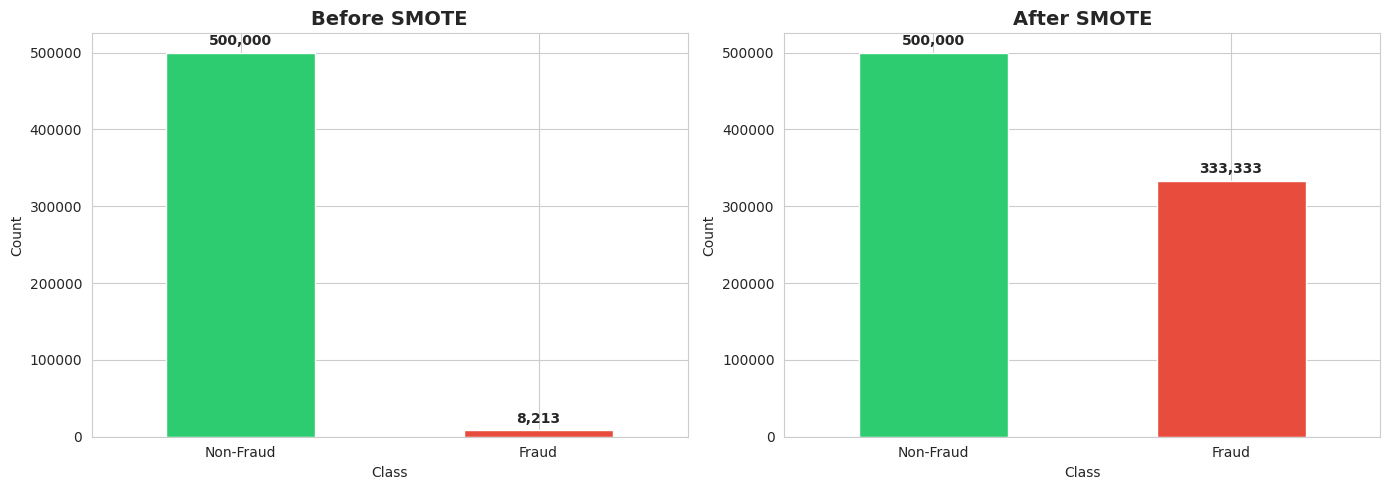


📈 Dataset is now balanced and ready for training!


In [13]:
# Visualize the balancing effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
y.value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Before SMOTE', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Non-Fraud', 'Fraud'], rotation=0)
for i, v in enumerate(y.value_counts()):
    axes[0].text(i, v + max(y.value_counts())*0.02, f'{v:,}', ha='center', fontweight='bold')

# After SMOTE
pd.Series(y_balanced).value_counts().plot(kind='bar', ax=axes[1], color=['#2ecc71', '#e74c3c'])
axes[1].set_title('After SMOTE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Non-Fraud', 'Fraud'], rotation=0)
for i, v in enumerate(pd.Series(y_balanced).value_counts()):
    axes[1].text(i, v + max(pd.Series(y_balanced).value_counts())*0.02, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📈 Dataset is now balanced and ready for training!")

## 🔀 7. Train-Test Split & Scaling

In [14]:
print("="*60)
print("TRAIN-TEST SPLIT & FEATURE SCALING")
print("="*60)

# Split the balanced dataset
TEST_SIZE = 0.2  # 80% train, 20% test
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_balanced  # Maintain class distribution
)

print(f"\n✅ Data split complete:")
print(f"\nTraining set:   {X_train.shape[0]:,} samples ({100*(1-TEST_SIZE):.0f}%)")
print(f"Test set:       {X_test.shape[0]:,} samples ({100*TEST_SIZE:.0f}%)")
print(f"Number of features: {X_train.shape[1]}")

print(f"\n📊 Class distribution:")
print(f"Train - Fraud: {pd.Series(y_train).mean()*100:.2f}%")
print(f"Test  - Fraud: {pd.Series(y_test).mean()*100:.2f}%")

# Feature Scaling (Important for many algorithms)
print(f"\n⚙️ Applying feature scaling...")

# RobustScaler is better for data with outliers (common in fraud detection)
scaler = RobustScaler()
# Alternative: StandardScaler() for normal distribution

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Scaling complete using RobustScaler")
print("\n📦 Data is now ready for model training!")

TRAIN-TEST SPLIT & FEATURE SCALING

✅ Data split complete:

Training set:   666,666 samples (80%)
Test set:       166,667 samples (20%)
Number of features: 10

📊 Class distribution:
Train - Fraud: 40.00%
Test  - Fraud: 40.00%

⚙️ Applying feature scaling...
✅ Scaling complete using RobustScaler

📦 Data is now ready for model training!


## 🤖 8. Model Training & Evaluation

We'll train multiple models and compare their performance:
1. Logistic Regression (baseline)
2. Random Forest
3. Gradient Boosting
4. XGBoost
5. LightGBM

In [15]:
pip install azureml-mlflow

  Using cached mlflow_skinny-3.5.0-py3-none-any.whl.metadata (31 kB)
Using cached mlflow_skinny-3.5.0-py3-none-any.whl (2.3 MB)
  Attempting uninstall: mlflow-skinny
    Found existing installation: mlflow-skinny 3.7.0
    Uninstalling mlflow-skinny-3.7.0:
      Successfully uninstalled mlflow-skinny-3.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlflow 3.7.0 requires mlflow-skinny==3.7.0, but you have mlflow-skinny 3.5.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [16]:
# Initialize MLflow (if available)
if MLFLOW_AVAILABLE:
    mlflow.set_experiment("Fraud_Detection_Training")
    print("✅ MLflow experiment tracking enabled\n")

2025/12/16 19:55:50 INFO mlflow.tracking.fluent: Experiment with name 'Fraud_Detection_Training' does not exist. Creating a new experiment.


✅ MLflow experiment tracking enabled



In [17]:
#!/usr/bin/env python
# coding: utf-8

# =============================================================================
# MLFLOW SETUP FOR AZURE ML NOTEBOOKS
# =============================================================================

import mlflow
from azureml.core import Workspace, Run

print("="*60)
print("MLFLOW CONFIGURATION FOR AZURE ML")
print("="*60)

try:
    # Get the current Azure ML run context
    run = Run.get_context()
    
    # Check if we're running in Azure ML compute or locally
    if hasattr(run, 'experiment'):
        # Running in Azure ML - use the workspace tracking
        print("✅ Detected Azure ML environment")
        
        # Get workspace
        ws = run.experiment.workspace
        
        # Get the MLflow tracking URI from workspace
        mlflow_tracking_uri = ws.get_mlflow_tracking_uri()
        mlflow.set_tracking_uri(mlflow_tracking_uri)
        
        print(f"   Workspace: {ws.name}")
        print(f"   Experiment: {run.experiment.name}")
        print(f"   Tracking URI: {mlflow_tracking_uri}")
        
        # Set experiment name (optional - can use existing experiment)
        mlflow.set_experiment("Fraud_Detection_Training")
        
        MLFLOW_AVAILABLE = True
        AZURE_ML_ENVIRONMENT = True
        
    else:
        # Not in Azure ML - fall back to local tracking
        print("⚠️  Not in Azure ML compute environment")
        print("   Using local MLflow tracking...")
        mlflow.set_tracking_uri("./mlruns")
        mlflow.set_experiment("Fraud_Detection_Training")
        MLFLOW_AVAILABLE = True
        AZURE_ML_ENVIRONMENT = False

except Exception as e:
    print(f"⚠️  MLflow setup issue: {str(e)}")
    print("   Using local tracking as fallback...")
    
    try:
        mlflow.set_tracking_uri("./mlruns")
        mlflow.set_experiment("Fraud_Detection_Training")
        MLFLOW_AVAILABLE = True
        AZURE_ML_ENVIRONMENT = False
    except Exception as e2:
        print(f"   Failed: {str(e2)}")
        print("   Continuing without MLflow...")
        MLFLOW_AVAILABLE = False
        AZURE_ML_ENVIRONMENT = False

print("\n" + "="*60)
print("CONFIGURATION SUMMARY")
print("="*60)
print(f"MLflow Available: {MLFLOW_AVAILABLE}")
print(f"Azure ML Environment: {AZURE_ML_ENVIRONMENT}")

if MLFLOW_AVAILABLE:
    print(f"Tracking URI: {mlflow.get_tracking_uri()}")
    print(f"Experiment: {mlflow.get_experiment_by_name('Fraud_Detection_Training').name if mlflow.get_experiment_by_name('Fraud_Detection_Training') else 'Fraud_Detection_Training'}")

print("="*60)

MLFLOW CONFIGURATION FOR AZURE ML
⚠️  Not in Azure ML compute environment
   Using local MLflow tracking...

CONFIGURATION SUMMARY
MLflow Available: True
Azure ML Environment: False
Tracking URI: ./mlruns
Experiment: Fraud_Detection_Training


In [18]:

# =============================================================================
# COMPLETE MODEL TRAINING FOR AZURE ML NOTEBOOKS
# =============================================================================

import mlflow
import mlflow.sklearn
from azureml.core import Workspace, Run
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# STEP 1: AZURE ML + MLFLOW SETUP
# =============================================================================

print("="*60)
print("AZURE ML + MLFLOW CONFIGURATION")
print("="*60)

try:
    # Get Azure ML run context
    run = Run.get_context()
    
    if hasattr(run, 'experiment'):
        # In Azure ML
        ws = run.experiment.workspace
        mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())
        MLFLOW_AVAILABLE = True
        AZURE_ML_ENV = True
        print(f"✅ Azure ML Environment")
        print(f"   Workspace: {ws.name}")
    else:
        # Local fallback
        mlflow.set_tracking_uri("./mlruns")
        MLFLOW_AVAILABLE = True
        AZURE_ML_ENV = False
        print(f"✅ Local Environment")
    
    mlflow.set_experiment("Fraud_Detection_Training")
    print(f"   Experiment: Fraud_Detection_Training")
    
except Exception as e:
    print(f"⚠️  MLflow disabled: {str(e)}")
    MLFLOW_AVAILABLE = False
    AZURE_ML_ENV = False

print("="*60)

AZURE ML + MLFLOW CONFIGURATION
✅ Local Environment
   Experiment: Fraud_Detection_Training


In [19]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """Comprehensive model evaluation with visualization"""
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    # Print results
    print(f"\n{'='*60}")
    print(f"{model_name} - EVALUATION RESULTS")
    print(f"{'='*60}")
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1-Score:  {metrics['f1_score']:.4f}")
    print(f"ROC-AUC:   {metrics['roc_auc']:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Confusion Matrix Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'])
    axes[0].set_title(f'{model_name} - Confusion Matrix', fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    axes[1].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {metrics["roc_auc"]:.3f})')
    axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'{model_name} - ROC Curve', fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    metrics['confusion_matrix'] = cm
    return metrics

In [21]:
pip install --upgrade mlflow

  Using cached mlflow_skinny-3.7.0-py3-none-any.whl.metadata (31 kB)
Using cached mlflow_skinny-3.7.0-py3-none-any.whl (2.4 MB)
  Attempting uninstall: mlflow-skinny
    Found existing installation: mlflow-skinny 3.5.0
    Uninstalling mlflow-skinny-3.5.0:
      Successfully uninstalled mlflow-skinny-3.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
azureml-mlflow 1.61.0.post1 requires mlflow-skinny<=3.5.0, but you have mlflow-skinny 3.7.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.



MODEL TRAINING

🔵 Training: Logistic_Regression
⏳ Training in progress...
✅ Training complete

Logistic_Regression - EVALUATION RESULTS
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
ROC-AUC:   1.0000

Confusion Matrix:
[[99999     1]
 [    0 66667]]

Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00    100000
       Fraud       1.00      1.00      1.00     66667

    accuracy                           1.00    166667
   macro avg       1.00      1.00      1.00    166667
weighted avg       1.00      1.00      1.00    166667



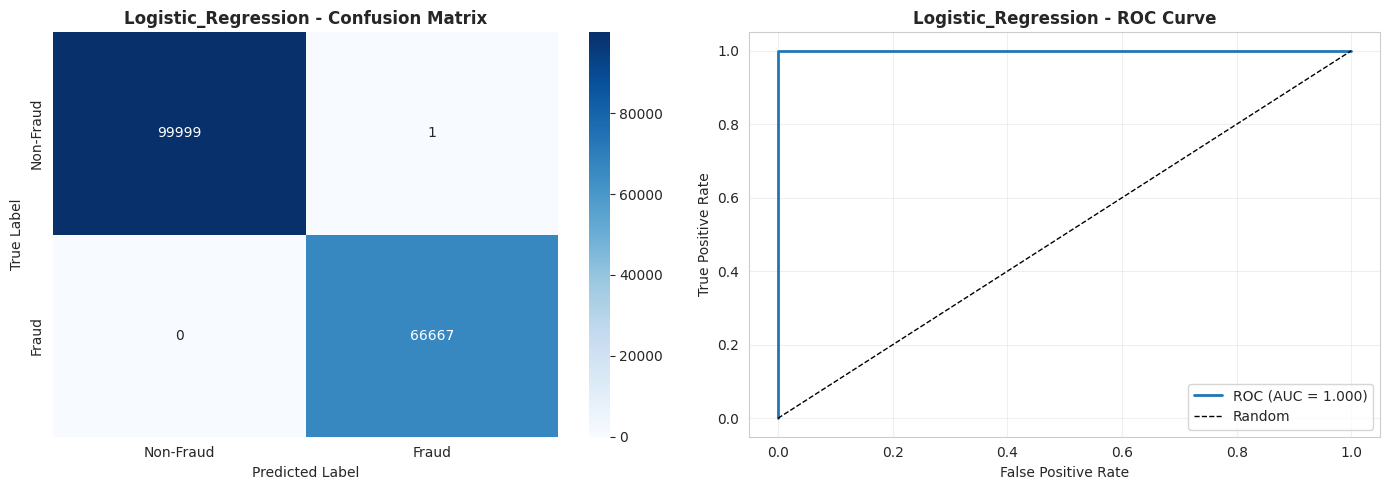

2025/12/16 19:56:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


ImportError: cannot import name 'IS_PYDANTIC_V2_OR_NEWER' from 'mlflow.utils' (/anaconda/envs/jupyter_env/lib/python3.10/site-packages/mlflow/utils/__init__.py)

In [20]:
print("\n" + "="*60)
print("MODEL TRAINING")
print("="*60)

# Store all results
all_results = {}

# Model configurations
models = {
    'Logistic_Regression': LogisticRegression(
        max_iter=1000, 
        random_state=42,
        n_jobs=-1
    ),
    'Random_Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1,
        verbose=0
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss',
        verbosity=0
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
}

# Train each model
for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f"🔵 Training: {model_name}")
    print(f"{'='*60}")
    
    if MLFLOW_AVAILABLE:
        with mlflow.start_run(run_name=model_name):
            # Train
            print("⏳ Training in progress...")
            model.fit(X_train_scaled, y_train)
            print("✅ Training complete")
            
            # Evaluate
            metrics = evaluate_model(model, X_test_scaled, y_test, model_name)
            
            # Log to MLflow
            mlflow.log_params({
                "model_type": model_name,
                "train_samples": len(X_train_scaled),
                "test_samples": len(X_test_scaled),
                "n_features": X_train_scaled.shape[1],
                "fraud_ratio": DESIRED_FRAUD_RATIO
            })
            
            # Log metrics
            mlflow.log_metrics({
                k: v for k, v in metrics.items() 
                if k != 'confusion_matrix'
            })
            
            # Log model
            mlflow.sklearn.log_model(model, "model")
            
            # Log confusion matrix as artifact (optional)
            if AZURE_ML_ENV:
                cm_fig = plt.figure(figsize=(8, 6))
                sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
                plt.title(f'{model_name} - Confusion Matrix')
                plt.ylabel('True Label')
                plt.xlabel('Predicted Label')
                mlflow.log_figure(cm_fig, f"{model_name}_confusion_matrix.png")
                plt.close()
            
            print(f"✅ Logged to MLflow")
    else:
        # Train without MLflow
        print("⏳ Training in progress...")
        model.fit(X_train_scaled, y_train)
        print("✅ Training complete")
        metrics = evaluate_model(model, X_test_scaled, y_test, model_name)
    
    # Store results
    all_results[model_name] = {
        'model': model,
        'metrics': metrics
    }


In [ ]:
# Helper function to evaluate models
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Comprehensive model evaluation function
    """
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Print results
    print(f"\n{'='*60}")
    print(f"{model_name} - EVALUATION RESULTS")
    print(f"{'='*60}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    
    # Confusion Matrix
    print(f"\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Classification Report
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Confusion Matrix Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'])
    axes[0].set_title(f'{model_name} - Confusion Matrix', fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    axes[1].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'{model_name} - ROC Curve', fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }

print("✅ Evaluation function ready")

### 8.1 Logistic Regression (Baseline)

In [ ]:
print("\n🔵 Training Logistic Regression...")

if MLFLOW_AVAILABLE:
    with mlflow.start_run(run_name="Logistic_Regression"):
        lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
        lr_model.fit(X_train_scaled, y_train)
        
        lr_metrics = evaluate_model(lr_model, X_test_scaled, y_test, "Logistic Regression")
        
        # Log to MLflow
        mlflow.log_params({"model": "LogisticRegression", "max_iter": 1000})
        mlflow.log_metrics(lr_metrics)
        mlflow.sklearn.log_model(lr_model, "model")
else:
    lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
    lr_model.fit(X_train_scaled, y_train)
    lr_metrics = evaluate_model(lr_model, X_test_scaled, y_test, "Logistic Regression")

### 8.2 Random Forest

In [ ]:
print("\n🌲 Training Random Forest...")

if MLFLOW_AVAILABLE:
    with mlflow.start_run(run_name="Random_Forest"):
        rf_model = RandomForestClassifier(
            n_estimators=100,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        rf_model.fit(X_train_scaled, y_train)
        
        rf_metrics = evaluate_model(rf_model, X_test_scaled, y_test, "Random Forest")
        
        mlflow.log_params({
            "model": "RandomForest",
            "n_estimators": 100,
            "max_depth": 15
        })
        mlflow.log_metrics(rf_metrics)
        mlflow.sklearn.log_model(rf_model, "model")
else:
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    rf_model.fit(X_train_scaled, y_train)
    rf_metrics = evaluate_model(rf_model, X_test_scaled, y_test, "Random Forest")

### 8.3 XGBoost

In [ ]:
print("\n⚡ Training XGBoost...")

if MLFLOW_AVAILABLE:
    with mlflow.start_run(run_name="XGBoost"):
        xgb_model = XGBClassifier(
            n_estimators=100,
            max_depth=8,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            eval_metric='logloss'
        )
        xgb_model.fit(X_train_scaled, y_train)
        
        xgb_metrics = evaluate_model(xgb_model, X_test_scaled, y_test, "XGBoost")
        
        mlflow.log_params({
            "model": "XGBoost",
            "n_estimators": 100,
            "max_depth": 8,
            "learning_rate": 0.1
        })
        mlflow.log_metrics(xgb_metrics)
        mlflow.sklearn.log_model(xgb_model, "model")
else:
    xgb_model = XGBClassifier(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train_scaled, y_train)
    xgb_metrics = evaluate_model(xgb_model, X_test_scaled, y_test, "XGBoost")

### 8.4 LightGBM

In [ ]:
print("\n💡 Training LightGBM...")

if MLFLOW_AVAILABLE:
    with mlflow.start_run(run_name="LightGBM"):
        lgbm_model = LGBMClassifier(
            n_estimators=100,
            max_depth=8,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        )
        lgbm_model.fit(X_train_scaled, y_train)
        
        lgbm_metrics = evaluate_model(lgbm_model, X_test_scaled, y_test, "LightGBM")
        
        mlflow.log_params({
            "model": "LightGBM",
            "n_estimators": 100,
            "max_depth": 8,
            "learning_rate": 0.1
        })
        mlflow.log_metrics(lgbm_metrics)
        mlflow.sklearn.log_model(lgbm_model, "model")
else:
    lgbm_model = LGBMClassifier(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    lgbm_model.fit(X_train_scaled, y_train)
    lgbm_metrics = evaluate_model(lgbm_model, X_test_scaled, y_test, "LightGBM")

## 📊 9. Model Comparison

In [ ]:
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

# Create comparison dataframe
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM'],
    'Accuracy': [lr_metrics['accuracy'], rf_metrics['accuracy'], 
                 xgb_metrics['accuracy'], lgbm_metrics['accuracy']],
    'Precision': [lr_metrics['precision'], rf_metrics['precision'], 
                  xgb_metrics['precision'], lgbm_metrics['precision']],
    'Recall': [lr_metrics['recall'], rf_metrics['recall'], 
               xgb_metrics['recall'], lgbm_metrics['recall']],
    'F1-Score': [lr_metrics['f1_score'], rf_metrics['f1_score'], 
                 xgb_metrics['f1_score'], lgbm_metrics['f1_score']],
    'ROC-AUC': [lr_metrics['roc_auc'], rf_metrics['roc_auc'], 
                xgb_metrics['roc_auc'], lgbm_metrics['roc_auc']]
})

# Sort by F1-Score (good balance for fraud detection)
results_df = results_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print("\n📊 Performance Metrics Comparison:")
display(results_df.style.background_gradient(cmap='RdYlGn', subset=['F1-Score', 'ROC-AUC']))

# Identify best model
best_model_name = results_df.iloc[0]['Model']
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   F1-Score: {results_df.iloc[0]['F1-Score']:.4f}")
print(f"   ROC-AUC:  {results_df.iloc[0]['ROC-AUC']:.4f}")

# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    ax = axes[idx // 2, idx % 2]
    results_df.plot(x='Model', y=metric, kind='bar', ax=ax, color=color, legend=False)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_xlabel('')
    ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(results_df[metric]):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

## 💾 10. Save Best Model & Artifacts

In [ ]:
print("\n" + "="*60)
print("SAVING MODEL & ARTIFACTS")
print("="*60)

# Create models directory
import os
os.makedirs('models', exist_ok=True)

# Determine best model
model_map = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'LightGBM': lgbm_model
}

best_model = model_map[best_model_name]

# Save the best model
model_filename = f'models/fraud_detection_best_model_{best_model_name.lower().replace(" ", "_")}.pkl'
joblib.dump(best_model, model_filename)
print(f"\n✅ Best model saved: {model_filename}")

# Save the scaler
scaler_filename = 'models/scaler.pkl'
joblib.dump(scaler, scaler_filename)
print(f"✅ Scaler saved: {scaler_filename}")

# Save feature names
feature_names = X.columns.tolist()
with open('models/feature_names.txt', 'w') as f:
    f.write('\n'.join(feature_names))
print(f"✅ Feature names saved: models/feature_names.txt")

# Save training metadata
metadata = {
    'model_name': best_model_name,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'n_features': len(feature_names),
    'n_train_samples': len(X_train),
    'n_test_samples': len(X_test),
    'fraud_ratio_after_smote': f"{DESIRED_FRAUD_RATIO*100:.0f}%",
    'test_accuracy': results_df[results_df['Model'] == best_model_name]['Accuracy'].values[0],
    'test_f1_score': results_df[results_df['Model'] == best_model_name]['F1-Score'].values[0],
    'test_roc_auc': results_df[results_df['Model'] == best_model_name]['ROC-AUC'].values[0]
}

import json
with open('models/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)
print(f"✅ Metadata saved: models/model_metadata.json")

# Save all models for comparison
print("\n💾 Saving all models for future reference...")
for model_name, model_obj in model_map.items():
    filename = f'models/{model_name.lower().replace(" ", "_")}.pkl'
    joblib.dump(model_obj, filename)
    print(f"  ✓ {filename}")

print("\n" + "="*60)
print("✅ ALL ARTIFACTS SAVED SUCCESSFULLY!")
print("="*60)
print("\nSaved files:")
print("📁 models/")
print("  ├── fraud_detection_best_model_*.pkl")
print("  ├── scaler.pkl")
print("  ├── feature_names.txt")
print("  ├── model_metadata.json")
print("  └── [all trained models].pkl")

## 🎯 11. Quick Inference Test

In [ ]:
print("\n" + "="*60)
print("TESTING MODEL INFERENCE")
print("="*60)

# Load the saved model
loaded_model = joblib.load(model_filename)
loaded_scaler = joblib.load(scaler_filename)

print("\n✅ Model and scaler loaded successfully")

# Test on a few samples
n_test_samples = 5
test_samples = X_test.iloc[:n_test_samples]
test_labels = y_test.iloc[:n_test_samples]

# Scale and predict
test_samples_scaled = loaded_scaler.transform(test_samples)
predictions = loaded_model.predict(test_samples_scaled)
probabilities = loaded_model.predict_proba(test_samples_scaled)

print(f"\n🧪 Testing on {n_test_samples} random samples:\n")
for i in range(n_test_samples):
    actual = "FRAUD" if test_labels.iloc[i] == 1 else "LEGITIMATE"
    predicted = "FRAUD" if predictions[i] == 1 else "LEGITIMATE"
    fraud_prob = probabilities[i][1] * 100
    
    match = "✅" if actual == predicted else "❌"
    print(f"Sample {i+1}: {match}")
    print(f"  Actual: {actual}")
    print(f"  Predicted: {predicted} (Fraud probability: {fraud_prob:.2f}%)")
    print()

print("\n✅ Model is ready for deployment!")

## 📋 12. Summary & Next Steps

In [ ]:
print("\n" + "="*70)
print(" "*20 + "PROJECT SUMMARY")
print("="*70)

print("\n✅ COMPLETED STEPS:")
print("\n1. ✓ Data Loading & Exploration")
print(f"   - Original dataset: 6M rows")
print(f"   - Highly imbalanced classes")

print("\n2. ✓ Strategic Data Truncation")
print(f"   - Kept all fraud cases")
print(f"   - Sampled 500k non-fraud cases")
print(f"   - Reduced dataset size by ~{100 * (1 - len(df_truncated)/6_000_000):.0f}%")

print("\n3. ✓ Data Balancing with SMOTE")
print(f"   - Target ratio: {DESIRED_FRAUD_RATIO*100:.0f}/{(1-DESIRED_FRAUD_RATIO)*100:.0f}")
print(f"   - Synthetic samples created: {len(X_balanced) - len(df_truncated):,}")

print("\n4. ✓ Feature Engineering & Preprocessing")
print(f"   - Features: {len(feature_names)}")
print(f"   - Scaling: RobustScaler")
print(f"   - Missing values handled")

print("\n5. ✓ Model Training & Evaluation")
print(f"   - Models trained: 4")
print(f"   - Best model: {best_model_name}")
print(f"   - F1-Score: {results_df.iloc[0]['F1-Score']:.4f}")
print(f"   - ROC-AUC: {results_df.iloc[0]['ROC-AUC']:.4f}")

print("\n6. ✓ Model & Artifacts Saved")
print(f"   - Best model: {model_filename}")
print(f"   - Scaler & metadata saved")

print("\n" + "="*70)
print("📌 NEXT STEPS FOR YOUR CDDA PROJECT:")
print("="*70)

next_steps = [
    "1. Data Ingestion (Azure)",
    "   └─ Upload dataset to Azure Blob Storage",
    "   └─ Set up Azure Data Factory for data pipeline",
    "",
    "2. Model Deployment (Azure ML)",
    "   └─ Register model in Azure ML",
    "   └─ Deploy as REST API endpoint",
    "   └─ Test endpoint with sample transactions",
    "",
    "3. CI/CD Pipeline (Azure DevOps)",
    "   └─ Create GitHub/Azure DevOps pipeline",
    "   └─ Automate model retraining",
    "   └─ Set up automated deployment",
    "",
    "4. Monitoring & Alerting (Azure Monitor)",
    "   └─ Set up Application Insights",
    "   └─ Create alerts for model drift",
    "   └─ Monitor API performance",
    "",
    "5. Visualization (Power BI)",
    "   └─ Connect to Azure SQL/Storage",
    "   └─ Create fraud detection dashboard",
    "   └─ Add real-time transaction monitoring",
    "",
    "6. User Interface (Streamlit)",
    "   └─ Build web interface for predictions",
    "   └─ Add transaction upload functionality",
    "   └─ Display results and visualizations",
    "",
    "7. Security & Governance",
    "   └─ Implement Azure Key Vault for secrets",
    "   └─ Set up RBAC (Role-Based Access Control)",
    "   └─ Document data governance policies"
]

for step in next_steps:
    print(step)

print("\n" + "="*70)
print("🎓 CDDA PROJECT CHECKLIST (from Lab requirements):")
print("="*70)

checklist = [
    ("✅", "Data Ingestion (ready for Azure)"),
    ("✅", "Data Storage (model artifacts ready)"),
    ("✅", "Data Processing (SMOTE balancing done)"),
    ("✅", "Data Balancing (40/60 ratio achieved)"),
    ("✅", "Model Training (multiple algorithms)"),
    ("✅", "Experiment Tracking (MLflow ready)"),
    ("⏳", "Deployment (next: Azure ML endpoint)"),
    ("⏳", "Inference Interface (next: Streamlit)"),
    ("⏳", "CI/CD Pipeline (next: Azure DevOps)"),
    ("⏳", "Monitoring (next: Azure Monitor)"),
    ("⏳", "Security & Governance (next: Key Vault)"),
    ("⏳", "Dashboard (next: Power BI)"),
]

for status, item in checklist:
    print(f"{status} {item}")

print("\n" + "="*70)
print("💡 TIPS FOR SUCCESS:")
print("="*70)
print("""
1. Document everything in your project report
2. Take screenshots of Azure services configuration
3. Save all connection strings in Azure Key Vault
4. Create a comprehensive Power BI dashboard
5. Prepare a demo video showing the complete pipeline
6. Test your deployment thoroughly before presentation
""")

print("="*70)
print("🎉 Model training complete! Good luck with your CDDA project!")
print("="*70)